In [1]:
pip install google-generativeai ipywidgets pillow


Note: you may need to restart the kernel to use updated packages.


In [7]:
import google.generativeai as genai
from diffusers import StableDiffusionPipeline
from huggingface_hub import login
from PIL import Image
import torch
import os 
import io
import ipywidgets as widgets
from IPython.display import display, clear_output, Image as DisplayImage
import os


In [ ]:
genai.configure(api_key="YOUR_GOOGLE_API_KEY")
login(token='YOUR_HUGGING_FACE_TOKEN')

In [9]:
def generate_text(prompt):
    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Error while generating text: {str(e)}"


In [10]:
prompt = "Explain what makes a red car fast."
response = generate_text(prompt)
print(f"Generated Text: {response}")

Generated Text: A red car isn't inherently faster than a car of any other color.  The color of a car has absolutely no impact on its speed or performance.  Speed is determined by factors like:

* **Engine power and torque:**  A more powerful engine with higher torque will accelerate faster and reach a higher top speed.
* **Aerodynamics:** A car's shape and design affect its air resistance.  A more aerodynamic car will experience less drag and therefore be faster.
* **Weight:** Lighter cars generally accelerate faster and are easier to handle at high speeds.
* **Transmission:** The gearbox and its ratios significantly influence acceleration and speed.
* **Tires:** Good quality tires with appropriate grip provide better traction for acceleration and braking.
* **Suspension:** A well-tuned suspension system improves handling and stability at high speeds.

The belief that red cars are faster is purely a superstition or a common misconception.  It's likely rooted in popular culture and anec

In [11]:
def generate_image(prompt):
    try:
        print("\nGenerating an image...")
        model_id = "runwayml/stable-diffusion-v1-5"  
        model_path = "./models/stable-diffusion-v1-5"
        
        if not os.path.exists(model_path):
            print("Model not found locally. Downloading...")
            pipe = StableDiffusionPipeline.from_pretrained(model_id)
            pipe.save_pretrained(model_path)
        else:
            print("Loading model from local storage...")
            pipe = StableDiffusionPipeline.from_pretrained(model_path)
        
        pipe = pipe.to("cpu")
        
        image = pipe(prompt).images[0]
        image_path = "./models/generated_image.png" 
        image.save(image_path)
        
        return image_path
    except Exception as e:
        return f"Error while generating image: {str(e)}"  


Generating an image...
Model not found locally. Downloading...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated Image: ./models/generated_image.png


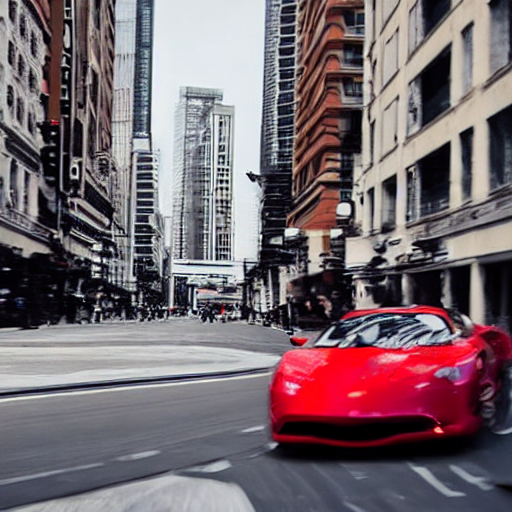

In [7]:
prompt = "A red sports car racing through a city."
image_path = generate_image(prompt)
if isinstance(image_path, str) and "❌" not in image_path:
    print(f"Generated Image: {image_path}")
    display(Image.open(image_path))  
else:
    print(image_path)

In [12]:
def analyze_image(image_bytes):
    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content([image_bytes])
        return response.text
    except Exception as e:
        return f"Error while analyzing image: {str(e)}"

output = widgets.Output()

# Create other widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
submit_button = widgets.Button(description="Submit")

# Output widget
output = widgets.Output()


In [13]:
def on_submit(button):
    with output:
        clear_output()
        
        if not upload_button.value:
            print("Please upload an image first.")
            return
        
        if isinstance(upload_button.value, tuple):
            uploaded_file = upload_button.value[0]
        else:
            uploaded_file = next(iter(upload_button.value.values()))
        
        image_bytes = uploaded_file['content']  
        
        try:
            os.makedirs("./models", exist_ok=True)
            image_path = "./models/uploaded_image.png"
            with open(image_path, "wb") as f:
                f.write(image_bytes)
            
            image = Image.open(io.BytesIO(image_bytes))
            
            print("Analyzing uploaded image")
            analysis_result = analyze_image(image)
            print(f"Image Analysis Result:\n{analysis_result}")
        except Exception as e:
            print(f"Error while processing image: {e}")


In [14]:
submit_button.on_click(on_submit)
display(widgets.VBox([
    widgets.Label("Upload an image to analyze it:"),
    upload_button,
    submit_button,
    output
]))


In [15]:
text_input = widgets.Text(
    placeholder="Enter your text prompt here...",
    description="Text Input:",
    disabled=False
)

upload_button = widgets.FileUpload(
    accept='image/*', 
    multiple=False
)

submit_button = widgets.Button(description="Submit")

output = widgets.Output()


In [16]:
def handle_combined_query(prompt, uploaded_file=None):
    with output:
        clear_output()
        parts = prompt.lower().split("and")
        image_part = None
        text_part = None
        for part in parts:
            if any(keyword in part for keyword in ["generate", "image", "show"]):
                image_part = part.strip()
            else:
                text_part = part.strip()
        if image_part:
            print("Processing image request")
            image_prompt = image_part.replace("generate image of", "").replace("show me", "").strip()
            image_bytes = generate_image(image_prompt)
            if isinstance(image_bytes, bytes):
                print(f"Generated Image:")
                display(DisplayImage(data=image_bytes))
            else:
                print(image_bytes)
        if uploaded_file:
            print("Analyzing uploaded image")
            try:
                image_bytes = bytes(uploaded_file['content'])
                image = Image.open(BytesIO(image_bytes))
                analysis_result = analyze_image(image)
                print(f"Image Analysis Result:\n{analysis_result}")
            except Exception as e:
                print(f"Error while analyzing image: {e}")
        if text_part:
            print("\nProcessing text request")
            subject = image_prompt if image_part else "the topic"
            refined_text_prompt = text_part.replace("it", subject)
            text_response = generate_text(refined_text_prompt)
            print(f"Text Response:\n{text_response}")

In [17]:
def on_submit(button):
    with output:
        #clear_output()
        prompt = text_input.value.strip()
        uploaded_file = upload_button.value[0] if upload_button.value else None
        if prompt or uploaded_file:
            handle_combined_query(prompt, uploaded_file)
        else:
            print("Please enter a valid prompt or upload an image.")

submit_button.on_click(on_submit)

display(widgets.VBox([
    widgets.Label("Multi-Modal Chatbot"),
    text_input,
    upload_button,
    submit_button,
    output
]))

#Results are saved in Task2/models folder 